# 1. 프로젝트 : Data Labeling
① Price Change Direction 적용하기    
② Using Moving Average 적용하기    
③ Local Min-Max 적용하기    
④ Trend Scanning 적용하기    

In [1]:
#라이브러리 가져오기
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

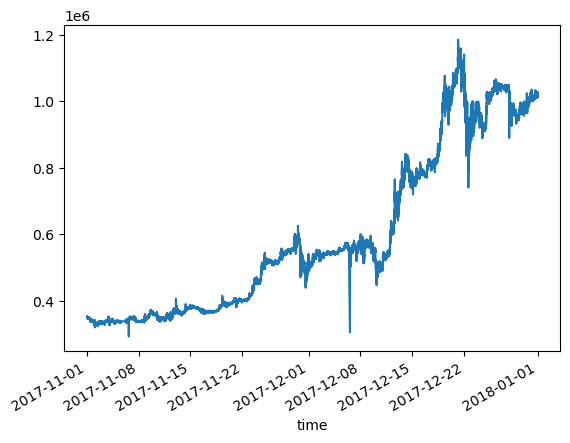

In [ ]:

# 데이터 불러오기
modify_data = pd.read_csv(r'C:\Users\nini\Desktop\TimeSeriese_Learning_training\training\data\sub_upbit_eth_min_tick.csv')

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

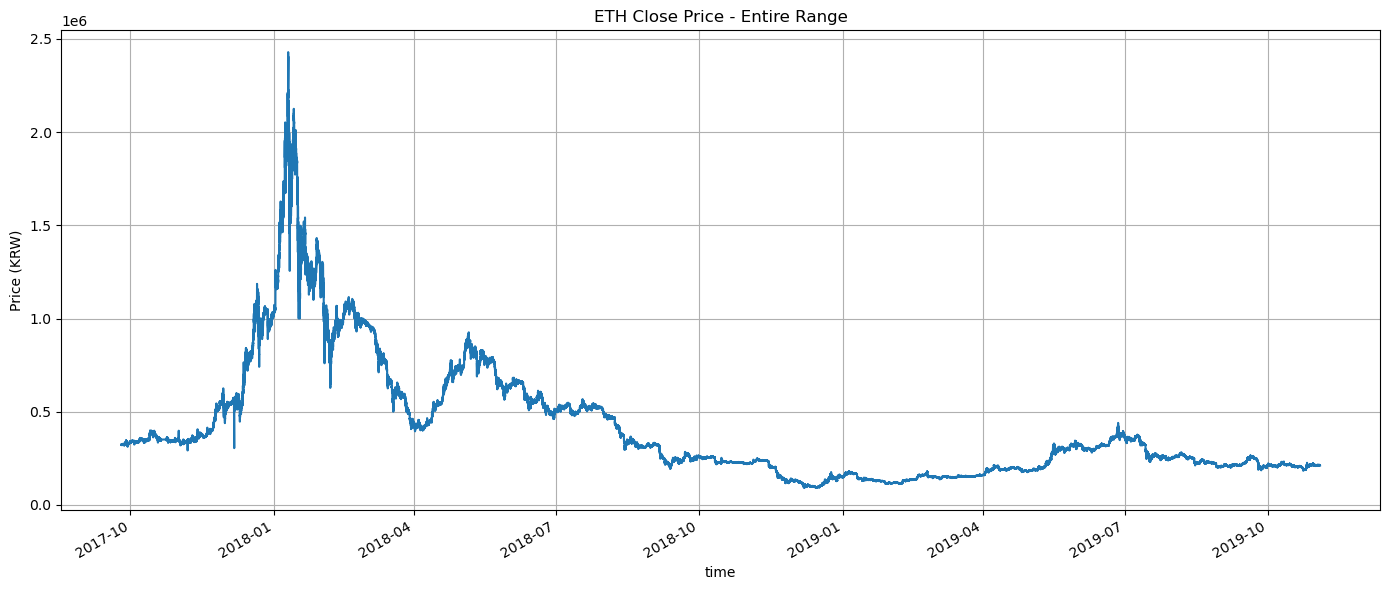

In [3]:
# 시각적으로 이상치나 추세 확인을 위해 전체 close 시각화
plt.figure(figsize=(14, 6))
modify_data['close'].plot(title='ETH Close Price - Entire Range')
plt.ylabel('Price (KRW)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# 데이터 정보 확인하기
modify_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2017-09-25 03:00:00 to 2019-11-03 10:33:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1000000 non-null  int64  
 1   high    1000000 non-null  int64  
 2   low     1000000 non-null  int64  
 3   close   1000000 non-null  int64  
 4   volume  1000000 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 45.8 MB


In [5]:
# 데이터 첫 5줄 확인하ㅠ기
modify_data.head()

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544


In [6]:
# describe() 확인
modify_data.describe()

,open,high,low,close,volume
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,4.253176e+05,4.257226e+05,4.249156e+05,4.253163e+05,7.350044e+01
std,3.367363e+05,3.372935e+05,3.361812e+05,3.367336e+05,1.799831e+02
min,9.247000e+04,9.251000e+04,9.245000e+04,9.247000e+04,1.000000e-08
25%,2.047000e+05,2.048000e+05,2.046000e+05,2.047000e+05,7.075016e+00
50%,2.981000e+05,2.982500e+05,2.979500e+05,2.981000e+05,2.581179e+01
75%,5.438000e+05,5.441000e+05,5.433000e+05,5.438000e+05,7.306149e+01
max,2.429000e+06,2.437000e+06,2.421000e+06,2.429000e+06,1.464788e+04


이 데이터셋은 업비트(Upbit)에서 제공하는 **ETH/원화 마켓의 분 단위 가격 정보**로, 총 1,000,000개의 레코드가 존재합니다.     
인덱스는 시간(`DatetimeIndex`)으로 설정되어 있으며, **2017년 9월 25일부터 2019년 11월 3일까지**의 이더리움 거래 데이터를 포함하고 있습니다.  
    
이 데이터셋은 총 5개의 열로 구성되어 있으며, 모두 결측치 없이 100만 개의 값을 가지고 있습니다. 각 열은 다음과 같은 의미를 가집니다.

- `open` : 해당 분의 시작 가격을 의미합니다.  
- `high` : 해당 분 동안 기록된 최고 가격입니다.  
- `low` : 해당 분 동안 기록된 최저 가격입니다.  
- `close` : 해당 분의 마지막(종가) 가격입니다.  
- `volume` : 해당 분 동안 거래된 수량입니다.  
    
가격 관련 변수는 모두 정수형(`int64`)이며, 거래량(`volume`)은 실수형(`float64`)입니다.      
종가(`close`) 기준으로는 평균 약 42만 원, 최대값은 약 243만 원, 최소값은 약 9만 원으로 가격 변동성이 매우 큰 시계열 데이터입니다.

- 이 데이터는 **ETH 가격의 급격한 변동성을 포함한 시계열 특성**을 잘 담고 있으며, 시세 분석 및 이상치 탐지 등에 적합한 구조를 가지고 있습니다.
- 2017년 말에는 큰 상승세가 있었고, 이후에는 전반적으로 하락세를 보이며 장기 침체기를 겪은 것을 알 수 있었습니다.
- **데이터 정제 없이 바로 사용할 수 있을 정도로 완성도 높은 정형 데이터**입니다.


#  Price Change Direction 적용하기
아래의 수식을 적용하여 momentum_signal을 만들어봅시다. 그리고 기존의 데이터(modify_data)와     
수식이 적용된 데이터(momentum_signal)를 시각화하여 어떤 차이가 있는지 비교해보기    
    
$
\text{Label } i(t) = \begin{cases}
1, & \text{if } \text{price}_t - \text{price}_{t-n} > 0 \\
0, & \text{otherwise}
\end{cases}
$

먼저 window를 설정합니다.    
보통 window는 시계열 데이터에서 이전 시점과 현재 시점간의 간격을 구간별로 잘라서 사용하곤합니다.    
이렇게 사용하는 이유는 정확한 예측을 달성하기 위해 우리가 가지고 있는 정보를 과거로 부터 주어진 시점에서    
가능한 안전하게 보존된 정보를 모델에 제공하기 위해 window로 다시 구성한 다음 모델에 input으로 주입하는 것입니다.    
window는 보통 time series data 외에도 많이 사용하는 기법입니다.    
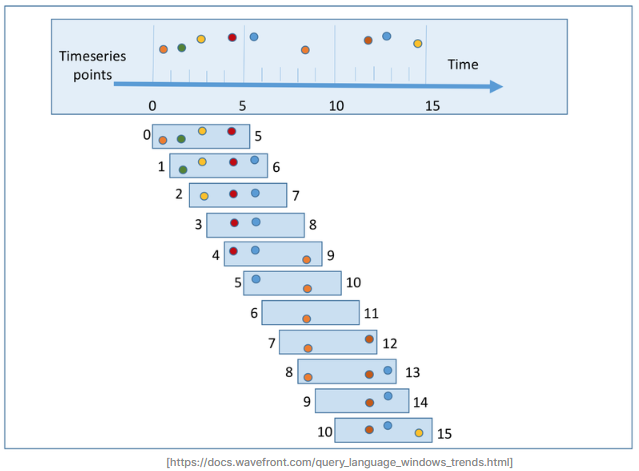

In [7]:
# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index = modify_data.index) # 데이터 활용을 위해 pd.Series를 사용합니다.

In [8]:
s_momentum_signal

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
                      ... 
2019-11-03 10:29:00    1.0
2019-11-03 10:30:00    0.0
2019-11-03 10:31:00    0.0
2019-11-03 10:32:00    0.0
2019-11-03 10:33:00    0.0
Name: close, Length: 1000000, dtype: float64

기존의 데이터(modify_data)에서 필요한 close(종가)를 가져오고 수식이 적용된 데이터(s_momentum_signal)의     
종가와 얼마나 차이가 있는지 확인하기 위해 데이터를 변환하고 시각화합니다.

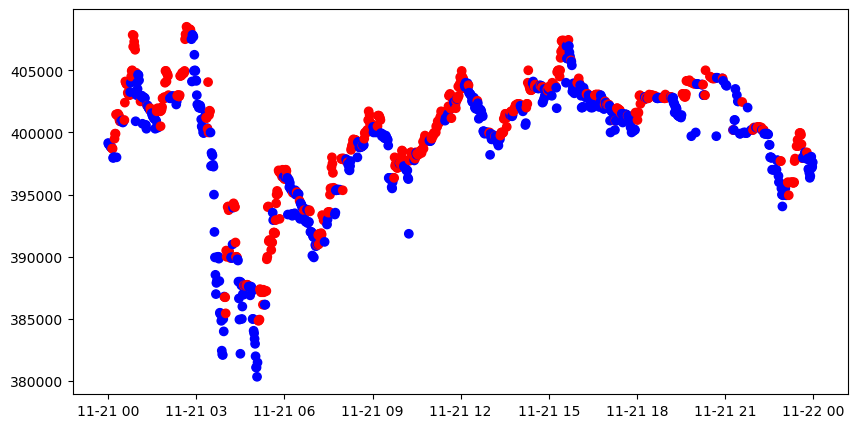

In [9]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기
c_sig = pd.DataFrame({'signal': c_sig})

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig['signal'] == 1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
plt.show()

10분 전 종가와 현재 종가를 비교하여 계산한 이진 모멘텀 신호(`s_momentum_signal`)는 가격이 상승 중이면 1, 그렇지 않으면 0으로 표시됩니다.
- **빨간색 점 (red)**: 가격이 10분 전보다 상승한 구간 (상승 모멘텀 신호 = 1)
- **파란색 점 (blue)**: 가격이 10분 전보다 정체 또는 하락한 구간 (신호 = 0)
- **하루 동안 모멘텀이 자주 전환되며 뚜렷한 추세 없이 등락을 반복한 장세라고 할 수 있습니다.**

## Using Moving Average 적용하기
앞서 사용했던 이동평균선을 이용한 방식을 적용해봅시다. 수식은 아래과 같습니다.  
    
$
\text{Label } i(t) = \begin{cases}
1, & \text{if } \text{price}_t > MA(t, \ldots, t-n) \\
0, & \text{if else}
\end{cases}
$

In [10]:
# Q. 코드를 작성해주세요

# momentum_signal # modify_data['close'].rolling(window).mean() 활용
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) 

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # pd.Series로 변환

앞서 "Price Change Direction 적용하기"에서 진행했던 것처럼 시각화를 위해      
Using Moving Average 수식을 적용한 것과 비교하기 위해 데이터를 변환하여 시각화를 통해 확인합니다.

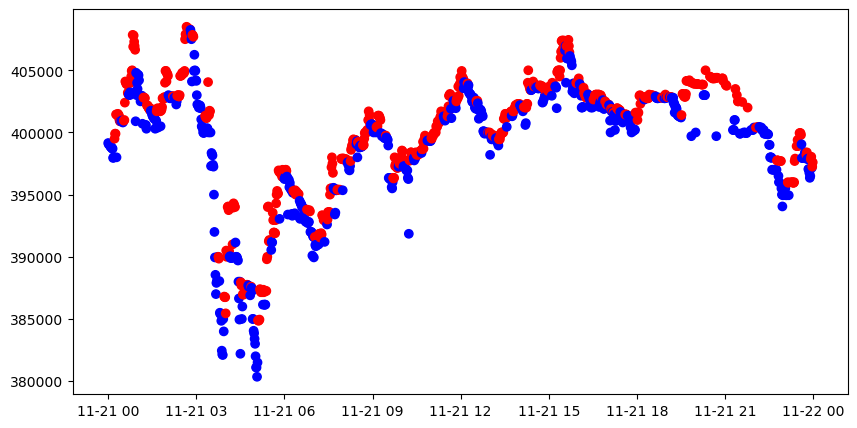

In [11]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig = pd.DataFrame({'signal': c_sig})

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig['signal'] == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

이번에는 10분 단순이동평균(MA)을 기준으로 종가가 그보다 높은지 여부를 이진 신호(1, 0)로 변환한 `s_momentum_signal`을 시각화하였습니다.

- **빨간색 점(Red)**: 현재 종가가 10분 이동평균보다 높은 시점 (`signal` = 1)
- **파란색 점(Blue)**: 현재 종가가 이동평균보다 낮거나 같은 시점 (`signal` = 0)
    
**시각화를 통해 알 수 있는 점**
- **빨간색 점이 일정 구간 지속**되는 부분은 **강한 단기 상승세**를 나타냅니다.
- 빨간색과 파란색이 **짧은 간격으로 번갈아 나타나는 경우**, 이는 **불안정하거나 노이즈가 많은 시장 상황**을 의미합니다.
- 이동평균 기반 신호는 이전에 사용한 단순 Price Change Direction 신호보다 **더 부드럽고 안정적인 추세 반영 효과**를 가질 수 있습니다.

## Local Min-Max 적용하기

①~⑦까지 코드를 자세히 들여다보고 어떠한 방식으로 코드가 동작되는지 뜯어봅시다.     
⑧ return 값은 dictionary 형태로 2개의 DataFrame이 반환되어야합니다.

In [12]:
# Q. 코드를 작성해주세요

# Local min / max 를 추출하기 위한 함수
# 일정 기간 동안 최저점과 최고점을 추적하며 지역적 극값(local extrema)을 찾아냄
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 #⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) # ⑧

get_local_min_max 함수를 사용하면 return 값이 2개가 나오게 됩니다. 아래 주석을 제거하여 min과 maxes의 값이 어떻게 나오는지 확인해봅시다.

In [13]:
# 위에서 정의한 함수로 지역적 최소값과 최대값을 추출함
mins, maxes = get_local_min_max(sub_data, wait=3)

In [14]:
# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

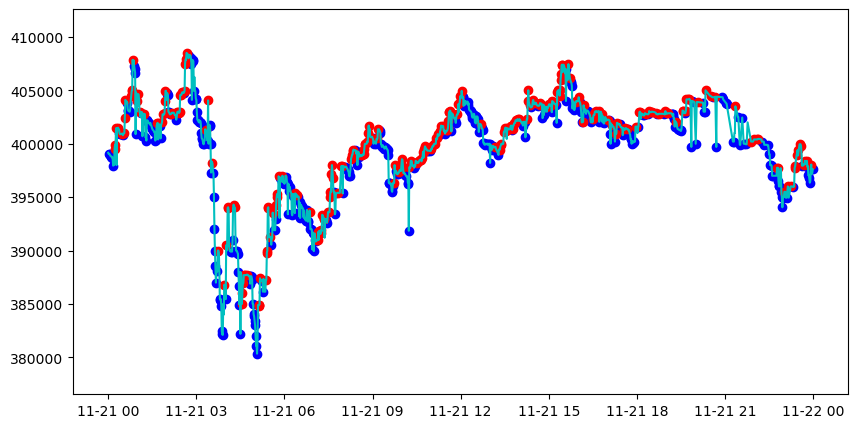

In [15]:
# Q. 코드를 작성해주세요

# 결과 시각화
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정 (범위를 확장해 명확해보이도록 설정)
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

`get_local_min_max()` 함수를 활용해 하루 동안의 종가 시계열에서 **지역적 최저점(min)**과 **지역적 최고점(max)**을 알아보았습니다.

- 지역적 최저점(Local Min): **477개**
- 지역적 최고점(Local Max): **273개**

---

**시각화를 통해 알 수 있는 점**
- **파란 점**은 지역적 저점(Local Min)을 나타내며, 가격이 떨어지다가 반등하는 지점을 포착합니다.
- **빨간 점**은 지역적 고점(Local Max)으로, 가격이 오르다가 하락 전환되는 지점입니다.
- 시계열 상에서 파란색과 빨간색이 교차되며 나타나는데, 이는 **짧은 단기 파동이 빈번하게 발생**하고 있음을 의미합니다.
- 일부 구간에서는 **고점과 저점 간 거리가 좁고 잦은 변동이 반복**되는데, 이는 해당 구간이 변동성이 높은 박스권(횡보장)이었음을 시사합니다.
- 반면 어떤 구간에서는 뚜렷한 **추세가 형성되며 고점과 저점이 명확히 분리**되기도 합니다.

> **참고사항**: “박스권” 또는 “횡보장”(횡보하는 장세)은 주식이나 코인, 선물 같은 금융 자산의 가격이 일정한 범위 안에서 오르락내리락만 하고 뚜렷한 상승이나 하락 없이 유지되는 상태를 말합니다.

## Trend Scanning 적용하기
Trend Scanning을 구현해봅시다.

$$
x_{t+1} = \beta_0 + \beta_1 \cdot 1 + \epsilon_{t+1}
$$

$$
\hat{t}_{\beta_1} = \frac{\beta_1}{\sigma_{\beta_1}}
$$

$$
\text{Label } i(t) = 
\begin{cases}
1, & \text{if } \max \hat{t}_{\beta_1} > 0 \\
0, & \text{if else}
\end{cases}
$$


     
OLS는 회귀분석을 하는 경우 유용하게 사용할 수 있으며 아래 함수에서 ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend)를 추정합니다.

In [16]:
# 선형 추세의 t값을 반환하는 함수 정의
def t_val_lin_r(close):
    import statsmodels.api as sml

    # x에는 상수항과 시간 인덱스를 포함
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])

    # OLS 회귀 모델 적합 후, 기울기의 t값 반환
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [17]:
# 슬라이딩 윈도우 기반 t값 추정에 사용할 설정값 초기화
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [18]:
# Q. 코드를 작성해주세요

# 회귀 기반 추세 분석을 위한 반복 루프 (실행 시간: 약 20~30분)
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values)) # t-value 사용

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

# 결과 저장 및 전처리
label.loc[molecule] = np.array(tmp_out)  # prevent leakage
label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [09:22<00:00, 59.37it/s]


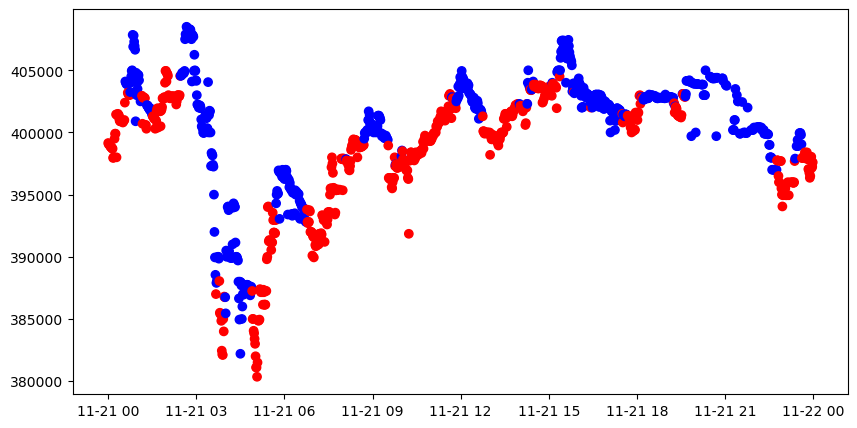

In [19]:
# 추세 레이블에 따라 색상 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig = pd.DataFrame({'bin': c_sig})
c_sig['color'] = np.where(c_sig['bin'] == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

Trend Scanning은 각 시점 기준으로 일정 시간(window) 동안 회귀분석을 반복 수행해,     
해당 구간의 선형 추세의 강도(t-value)를 계산하고 이를 통해 단기 추세의 방향성(상승/비상승)을 판단하는 기법입니다.

---

**시각화**
- **빨간색 점 (Red)**: 양(+)의 t-value → 상승 추세 인식
- **파란색 점 (Blue)**: 음(-)의 t-value 또는 0 → 비상승 구간 (하락 or 정체)

---

- 분석일(2017-11-21) 동안 상승 추세로 분류된 시점이 다수 존재함
- 하지만 빨간색과 파란색이 짧은 간격으로 반복되며 출현하는 구간도 많음    
  → 이는 **짧은 파동이 잦은 비추세 구간**이 섞여 있었음을 의미
- 특정 시간대에서는 **상승 추세가 비교적 길게 유지** 즉 일정 구간 강한 매수 흐름이 존재했음을 시사합니다.

# 2. 프로젝트 : Feature Engineering
① 환경구성 및 데이터 불러오기    
② Technical Index 적용하기    
③ Feature Selection methods 적용하기    

##  환경구성 및 데이터 불러오기

In [20]:
# 환경구성 및 데이터를 불러옵니다.
# !pip install ta==0.9.0
# !pip install shap

In [21]:
# 패키지 가져오기
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
# LMS의 내부 파일로 아래의 코드 실행
# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [22]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [23]:
# 데이터 경로 설정
DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
# target_file_name: CSV 형식의 가격 데이터
# anno_file_name: 라벨 정보 (pickle 파일)
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)

# 라벨이 존재하는 인덱스에 해당하는 가격 데이터만 필터링
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [24]:
# 데이터 확인하기
df_sub_modify_data

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404
...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849


In [25]:
# 라벨 확인
print(df_label_data.head())
print('-'*20),
print(df_label_data.tail())

time
2018-01-01 00:00:00   -0.0
2018-01-01 00:01:00   -0.0
2018-01-01 00:02:00   -0.0
2018-01-01 00:03:00   -1.0
2018-01-01 00:04:00   -1.0
Name: t_value, dtype: float64
--------------------
time
2019-11-03 10:29:00   NaN
2019-11-03 10:30:00   NaN
2019-11-03 10:31:00   NaN
2019-11-03 10:32:00   NaN
2019-11-03 10:33:00   NaN
Name: t_value, dtype: float64


In [26]:
# 라벨데이터 갯수 확인
df_label_data.value_counts()

t_value
-1.0    306636
-0.0    302963
 1.0    299289
Name: count, dtype: int64

- 전체 데이터 중 라벨이 존재하는 시점에 해당하는 가격 데이터만 추출했으며, 분석에는 앞부분 1000개 구간을 사용했습니다.
- 사용된 각 데이터 포인트는 분 단위로, `open`, `high`, `low`, `close`, `volume` 총 5개의 피처로 구성되어 있습니다.
- 사용된 데이터의 기간은 다음과 같습니다:
  - 시작 시점: 2018-01-01 00:00:00
  - 종료 시점: 2018-01-01 16:39:00

---

- 총 라벨 수: 약 90만 개 (전체 데이터 기준)
- 라벨은 가격 추세를 기준으로 **세 가지 값**으로 구분됩니다:
  - `1.0` → 상승 구간 (299,289건, 약 33%)
  - `-0.0` → 정체 구간 (302,963건, 약 34%)
  - `-1.0` → 하락 구간 (306,636건, 약 34%)    
**클래스가 비교적 균등하게 분포되어 있어, 클래스 불균형 문제가 크지 않음**을 알 수 있습니다.


## Technical Index 적용하기
앞서 배운 기술적 지표와 수익률/변동성 지표를 참고하여 코드를 뜯어봅시다.

In [27]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

위 코드는 시계열 가격 데이터(open, high, low, close, volume)를 기반으로 아래와 같은 총 15가지 기술 지표를 계산합니다.

- **Volume 기반**: 5개 (CMF, FI, MFI, EOM, VPT)
- **Volatility 기반**: 2개 (ATR, Ulcer Index)
- **Trend 기반**: 6개 (MACD, ADX, TRIX, Mass Index, DPO, Aroon)
- **Momentum 기반**: 2개 (RSI, Williams %R)

---

- **가격과 거래량의 상호작용**: CMF, VPT, Force Index 등을 통해 거래량을 동반한 상승/하락 여부를 감지할 수 있음
- **변동성의 정도**: ATR과 Ulcer Index는 급격한 변동이나 추세 붕괴 가능성을 포착함
- **추세 방향과 강도**: MACD, ADX, TRIX 등은 상승·하락 추세의 지속 가능성을 나타냄
- **단기 과매수/과매도**: RSI, Williams %R은 단기 조정 가능성을 암시


In [28]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


In [29]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20] # 변화율(모멘텀) 계산을 위한 기간 설정 (5일, 10일, 20일)
windows_std = [30]        # 표준편차 계산을 위한 기간 설정 (30일)

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)   # i일 전 대비 거래량 변화율 계산 (% 단위, 소수점 6자리까지 반올림)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)           # i일 전 대비 종가 변화율 계산 (% 단위, 소수점 6자리까지 반올림)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()          # i일 이동 창을 기준으로 종가의 표준편차 계산 (변동성 지표로 사용됨)
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()     # i일 이동 창을 기준으로 거래량의 표준편차 계산 (거래량의 변동성 측정)

In [30]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


* pct_change(i): i일 전 대비 퍼센트 변화율 계산
* rolling(i).std(): i일 구간의 이동 표준편차(변동성) 계산
* 결과는 각각 vol_change_5, ret_10, std_30 등으로 저장됨

이 단계에서는 가격과 거래량 시계열을 기반으로 수익률과 변동성 관련 파생 지표들을 생성했습니다.  
총 8개의 지표가 추가되었으며, 각각은 아래와 같은 분석적 의미를 가집니다.

---

* `ret_5`, `ret_10`, `ret_20`: 각각 5분, 10분, 20분 전 대비 종가의 변화율을 나타냅니다.
* `vol_change_5`, `vol_change_10`, `vol_change_20`: 각각 5분, 10분, 20분 전 대비 거래량의 변화율을 나타냅니다.
* `std_30`: 30분 동안의 종가의 표준편차로, 가격의 변동성을 측정합니다.
* `vol_std_30`: 30분 동안의 거래량의 표준편차로, 거래량의 변동성을 나타냅니다.

In [31]:

# df_와 df_label_data를 인덱스를 기준으로 결합(join)하고, 결측치가 있는 행은 제거(dropna)
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [32]:
# X_sc 데이터 확인
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


* df_.join(df_label_data).dropna()를 통해 라벨과 기술적 지표 데이터를 인덱스를 기준으로 병합하고, 결측값이 있는 행을 제거함
* 결측치 제거로 인해 일부 시점의 데이터가 학습 대상에서 제외됨
* StandardScaler로 모든 피처를 평균 0, 표준편차 1의 정규 분포 형태로 스케일링하여 모델 학습 시 변수 간 균형을 맞춤
* 스케일링 결과는 X_sc로 저장되고, 이후 머신러닝 모델의 입력으로 사용됨

In [33]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

In [34]:
from xgboost import XGBClassifier
import pandas as pd

# 모델 정의 및 학습
xgb_clf = XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1,
    use_label_encoder=False, 
    eval_metric='logloss'
)

y1 = y.replace(-1, 0)
y1 = y1.astype(int) 
xgb_clf.fit(X_sc, y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## Feature Selection methods 적용하기

### MDI, Mean Decrease Impurity

In [35]:
# MDI, Mean Decrease Impurity 
feat_imp = mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.049399,0.002082
volume_fi,0.036660,0.002108
volume_mfi,0.048237,0.002451
volume_sma_em,0.037922,0.001910
volume_vpt,0.026027,0.001576
volatility_atr,0.078297,0.003263
volatility_ui,0.045183,0.002346
trend_macd_diff,0.083455,0.004381
trend_adx,0.057051,0.002548
trend_trix,0.068920,0.003241


In [36]:
#중요도 상위 피처 확인
feat_imp.sort_values("mean", ascending=False).head(10)

,mean,std
trend_macd_diff,0.083455,0.004381
volatility_atr,0.078297,0.003263
trend_trix,0.068920,0.003241
trend_mass_index,0.067798,0.002944
vol_std_30,0.067791,0.002723
trend_adx,0.057051,0.002548
volume_cmf,0.049399,0.002082
std_30,0.048456,0.002196
volume_mfi,0.048237,0.002451
volatility_ui,0.045183,0.002346


In [37]:
# MDI, XGBoost 적용
# XGBClassifier 객체인 xgb_clf에서 내부의 Booster 객체를 가져오기
booster = xgb_clf.get_booster()

# 피처 중요도를 계산해주는 메서드
# importance_type='gain'은 해당 피처로 split해서 얻은 정보 이득(Gain)의 평균값을 반환
importance_dict = booster.get_score(importance_type='gain')  # 또는 'weight'

# 각 피처가 예측에 기여한 정도를 숫자로 보여주는 표만들기
feat_imp1 = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'mean': list(importance_dict.values())
})

# 중요도 상위 10개 출력
feat_imp.sort_values("mean", ascending=False).head(10)

,mean,std
trend_macd_diff,0.083455,0.004381
volatility_atr,0.078297,0.003263
trend_trix,0.068920,0.003241
trend_mass_index,0.067798,0.002944
vol_std_30,0.067791,0.002723
trend_adx,0.057051,0.002548
volume_cmf,0.049399,0.002082
std_30,0.048456,0.002196
volume_mfi,0.048237,0.002451
volatility_ui,0.045183,0.002346


**MDI (Mean Decrease Impurity)**  
  - 트리 기반 모델(RandomForest) 내에서 각 피처가 불순도를 얼마나 감소시키는지를 측정한 값  
  - 빠르고 직관적이며, 내부적으로 사용된 정보에 기반한 중요도 평가 방식  
  - volatility_atr, trend_macd_diff, trend_mass_index 등이 높은 중요도를 가짐

**MDI 모델에 XGBoost 사용해보기**
* RandomForest 모델을 적용한것과 동일한 순위가 나옴 

### MDA, Mean Decrease Accuracy

In [38]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해보기
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [39]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # 피처 중요도를 수평 막대그래프로 시각화하는 함수
    # 입력: importance_df (컬럼: 'mean', 'std'), save_fig (저장 여부), output_path (저장 경로)

    # 그래프 크기 설정 (높이는 피처 수에 따라 자동 조정)
    plt.figure(figsize=(10, importance_df.shape[0] / 5))

    # 중요도 평균 기준으로 오름차순 정렬 (가장 중요한 피처가 아래로 가도록)
    importance_df.sort_values('mean', ascending=True, inplace=True)

    # 수평 막대그래프 그리기
    importance_df['mean'].plot(
        kind='barh',              # 수평 막대 그래프
        color='b',                # 파란색 막대
        alpha=0.25,               # 투명도 0.25
        xerr=importance_df['std'],  # std 값을 오차 막대로 표시
        error_kw={'ecolor': 'r'}    # 오차 막대는 빨간색
    )

    # 결과를 저장하거나 화면에 출력
    if save_fig:
        plt.savefig(output_path)  # 파일로 저장
    else:
        plt.show()                # 화면에 바로 출력

plot_feature_importance 함수를 사용하여 feat_imp와 feat_imp_mda를 확인해봅시다.

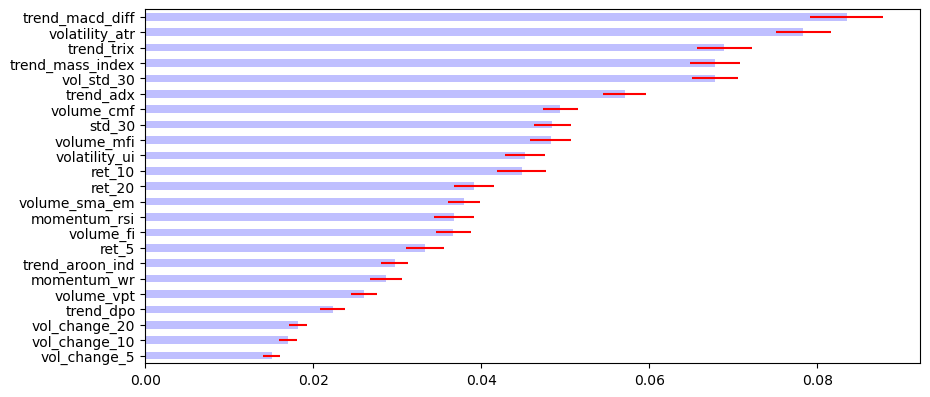

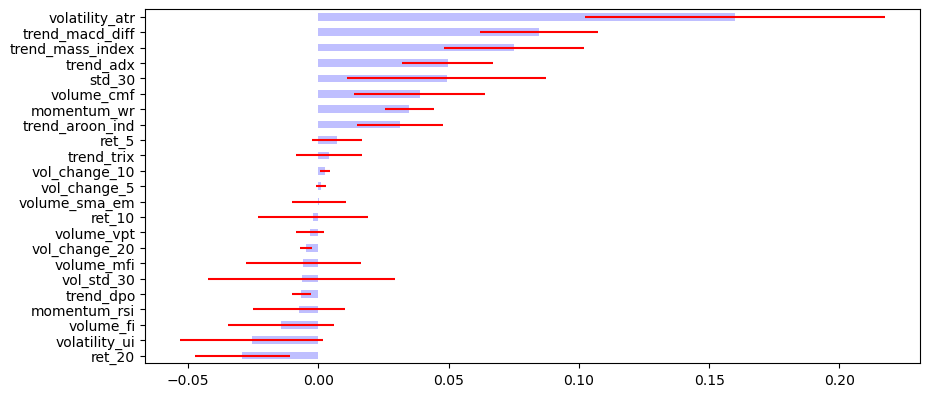

In [40]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [41]:
# Logistic Regression 모델로 MDA 계산
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Logistic Regression 모델 정의
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')  # solver는 데이터에 따라 'liblinear'도 가능

# 교차 검증 설정 (여기서는 10폴드)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# 데이터 프레임으로 변환해주기. 
X_sc_df = pd.DataFrame(X_sc, columns=X.columns) 

# MDA 계산
feat_imp_mda_logreg = mean_decrease_accuracy(logreg, X_sc_df, y, cv_gen=cv)

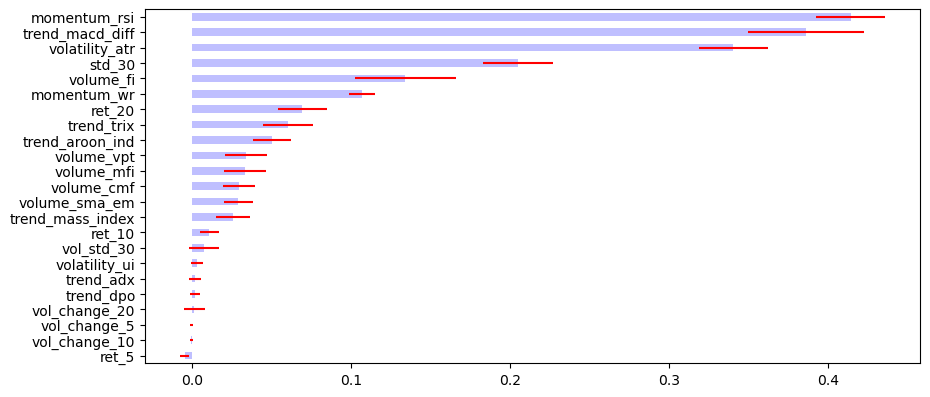

In [42]:
#  중요도 시각화
plot_feature_importance(feat_imp_mda_logreg)

**MDA (Mean Decrease Accuracy)**  
  - 피처를 무작위로 섞었을 때 모델 정확도가 얼마나 감소하는지를 기반으로 중요도 판단  
  - 트리 외 분류기(SVC RBF 커널)를 적용하여 피처의 일반적 예측 기여도를 측정  
  - volatility_atr, trend_macd_diff, trend_mass_index, std_30 순으로 주요 변수로 확인됨
    
**MDA Logistic Regression 모델로 MDA 계산**
  - 로지스틱 회귀 방식으로 중요도를 시각화진행
  - momentum_rsi, volatility_atr, trend_macd_diff, std_30, volume_fi 순으로 중요도가 나옴

#### 최종적으로 volatility_atr, trend_macd_diff은 중요도가 높은편이라고 생각이 들었습니다.

### RFE CV, Recursive Feature Elimination

In [43]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)

# 교차검증 기반 피처 선택 (RFECV) 설정
rfe_cv = RFECV(svc_rbf, cv=cv)

# 모델 학습 및 최적 피처 선택 수행
rfe_fitted = rfe_cv.fit(X_sc, y)

In [44]:
# 선택된 피쳐 확인하기

rfe_df = pd.DataFrame(
    [rfe_fitted.support_, rfe_fitted.ranking_],
    columns=X_sc.columns
).T.rename(columns={0: "Optimal_Features", 1: "Ranking"})

# 최적 피처 및 순위 데이터프레임 출력
rfe_df

,Optimal_Features,Ranking
volume_cmf,True,1
volume_fi,True,1
volume_mfi,False,2
volume_sma_em,True,1
volume_vpt,True,1
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_adx,False,7
trend_trix,True,1


In [45]:
# 순위
rfe_df.sort_values("Ranking", ascending=True).head(10)

,Optimal_Features,Ranking
volume_cmf,True,1
ret_20,True,1
momentum_wr,True,1
momentum_rsi,True,1
trend_aroon_ind,True,1
std_30,True,1
trend_mass_index,True,1
trend_trix,True,1
vol_std_30,True,1
trend_macd_diff,True,1


In [46]:
# RFE에서 선택된 최적의 피처들만 필터링하여 출력
rfe_df[rfe_df["Optimal_Features"] == True]

,Optimal_Features,Ranking
volume_cmf,True,1
volume_fi,True,1
volume_sma_em,True,1
volume_vpt,True,1
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_trix,True,1
trend_mass_index,True,1
trend_aroon_ind,True,1


**RFE (Recursive Feature Elimination)**  
  - 선형 SVC 기반으로 반복적으로 덜 중요한 피처를 제거하며 최적 피처 집합을 선택  
  - 선택된 피처로는 volatility_atr, trend_macd_diff, std_30
  - 모두 순위 1로 선택되어 **가장 안정적으로 모델 성능에 기여한 핵심 피처**로 판단됨   

### SFS, Sequential Feature Selection

In [47]:
# SFS, Sequential Feature Selection

n = 2  # 선택할 최적 피처 개수 설정

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [48]:
# 선택된 피쳐 확인하기

# 선택된 피처 여부(True/False)를 불리언 배열로 반환
sfs_rank = sfs_fitted.get_support()

# 선택된 피처 여부를 데이터프레임으로 변환 (인덱스: 피처 이름)
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

# 선택된 피처들의 이름(인덱스)만 추출
sfs_df[sfs_df["Optimal_Features"] == True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

**SFS (Sequential Feature Selection)**  
  - 성능을 가장 향상시키는 피처를 하나씩 추가하는 방식으로 최적 피처 조합 선택  
  - 지정된 2개의 피처로 volume_mfi, trend_macd_diff 선택됨
  - volume_mfi는 다른 기법에서는 상대적으로 중요도가 낮았으나, 조합 상에서 높은 성능 기여를 한 것으로 해석됨    

### SHAP, Shapley Additive explanations

In [49]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap_value = explainer.shap_values(X_sc)

In [50]:
# 객체의 크기 확인
shap_value.shape

(957, 23, 3)

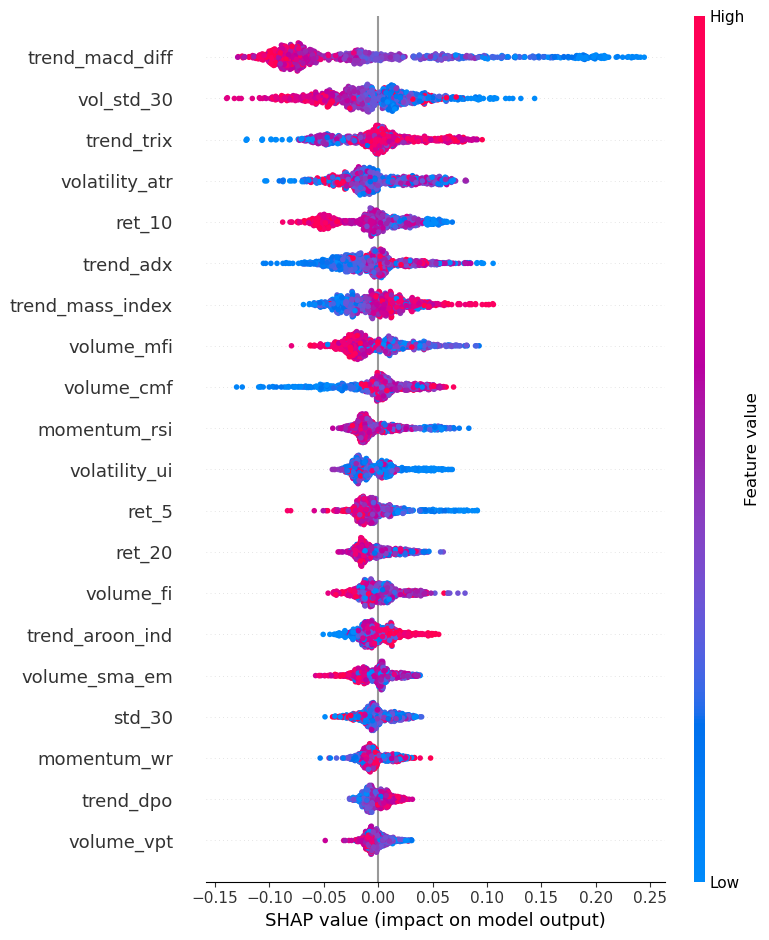

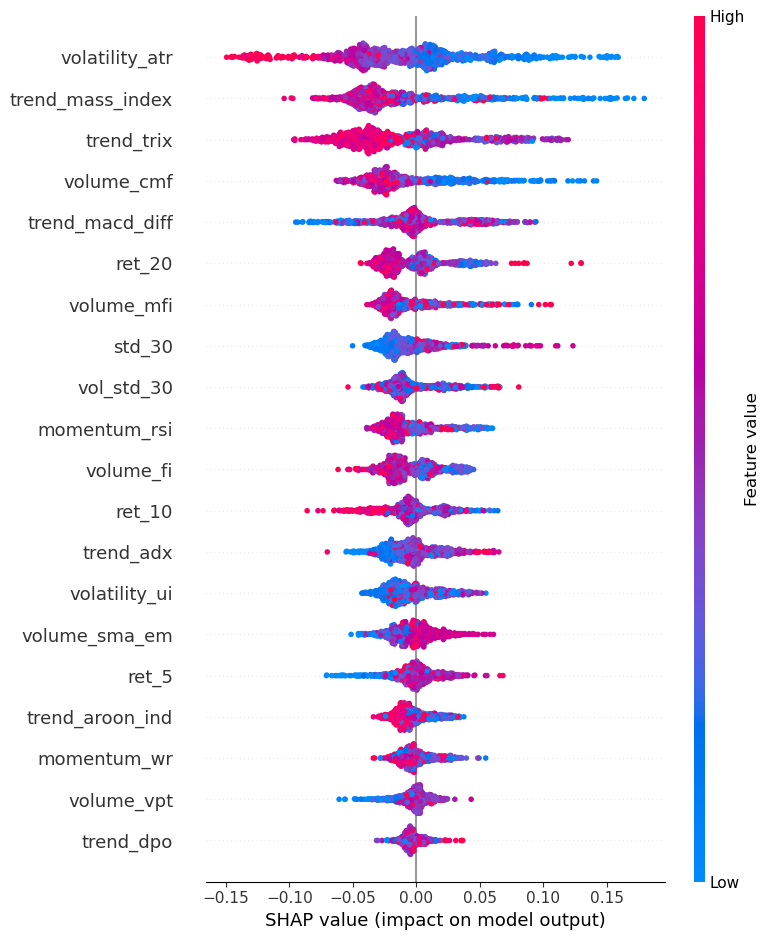

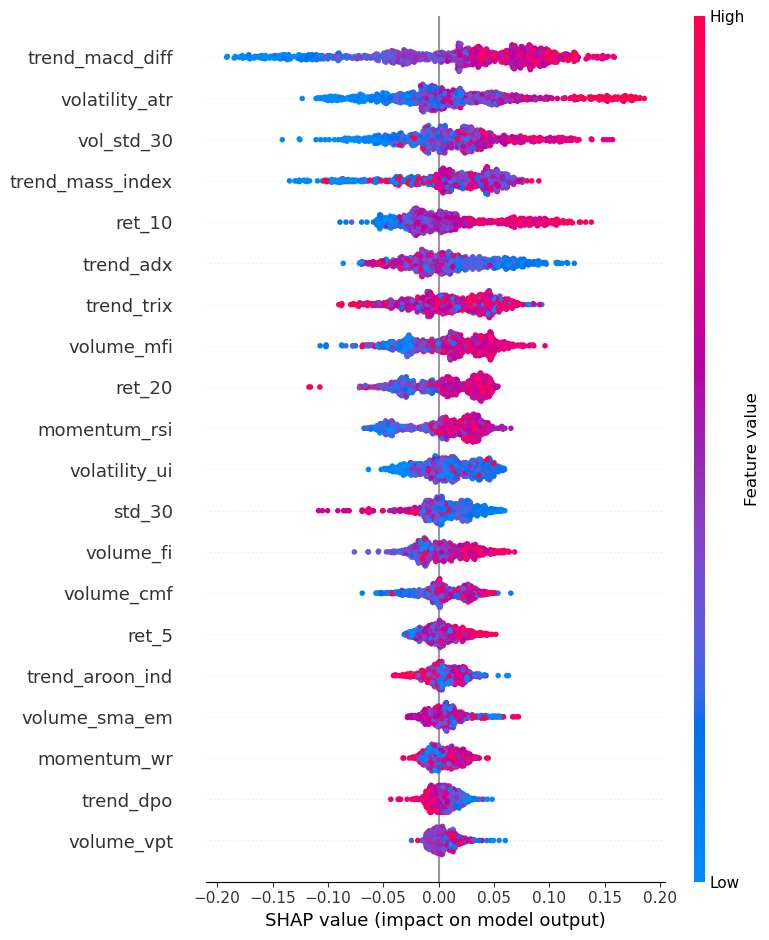

In [51]:
# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

    
**SHAP (SHapley Additive exPlanations)**  
  - 각 피처가 예측에 미친 영향을 샘플 단위로 시각화   
  - Tree 기반 모델을 기반으로 SHAP summary plot 시각화      

#### **피처 중요도 분석** 

이 단계에서는 다양한 피처 선택 및 중요도 평가 기법을 적용하여 예측 성능에 기여하는 핵심 피처들을 선별하였습니다.      
총 5가지 방법론(MDI, MDA, RFE, SFS, SHAP)을 통해 다각적으로 피처의 중요성을 검토했습니다.    
 


# 3. 프로젝트 : Model Traning
① 환경구성 및 데이터 불러오기    
② Purged K-fold for Cross-Validation적용하기    
③ Model 적용하기

## 환경구성 및 데이터 불러오기

In [52]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.mlutil.pkfold import PKFold

In [53]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

In [54]:
# 데이터불러오기
DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# 피클 파일에서 데이터프레임 로드
df_data = pd.read_pickle(data_file_name)

In [55]:
# 't_value' 컬럼에서 값이 1이면 그대로 두고, 나머지는 모두 0으로 변경 (이진분류)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

t_value
1.0    481
0.0    476
Name: count, dtype: int64

In [56]:
# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))   # 전체 데이터 길이에 따라 학습 데이터 개수 계산
n_test = int(np.round(len(df_data) * test_ratio))     # 전체 데이터 길이에 따라 테스트 데이터 개수 계산

In [57]:
# 피처(X)와 타겟(y) 분리
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation 피처 데이터(X)를 표준화
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [58]:
# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

# numpy 배열을 다시 pandas 형태로 변환 (인덱스와 컬럼 복원)
train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:500] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:500]

In [59]:
train_y.count()

500

In [60]:
train_x.count()

volume_cmf          500
volume_fi           500
volume_mfi          500
volume_sma_em       500
volume_vpt          500
volatility_atr      500
volatility_ui       500
trend_macd_diff     500
trend_adx           500
trend_trix          500
trend_mass_index    500
trend_dpo           500
trend_aroon_ind     500
momentum_rsi        500
momentum_wr         500
vol_change_5        500
ret_5               500
vol_change_10       500
ret_10              500
vol_change_20       500
ret_20              500
std_30              500
vol_std_30          500
dtype: int64

**데이터셋을 500으로 감소시키겠습니다.**    
train_x, train_y는 총 670개로 1000개로 설정해도 670개가 최대이기 때문에 500개로 조정해보겠습니다.

## Purged K-fold for Cross-Validation적용하기

In [61]:
n_cv = 5 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

**데이터 학습갯수가 500개 이기 때문에 n_cv를 5로 조정하여 5-fold 교차 검증을 해보겠습니다.**    
5개의 폴드로 나누면 각 검증 세트는 약 100개의 샘플을 가지게 되어 통계적으로 유의미한 결과를 얻을 수 있다고 생각합니다.    
폴드를 너무 많이 사용하게되면 계산 비용과 분산을 증가시킬 수 있기 때문에 적절한 값으로 지정하겠습니다.


## Model 적용하기

In [68]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {
    'n_estimators': [5, 10, 20],                      # 배깅에서 사용할 랜덤포레스트 개수
    'max_features': [0.5, 0.7],                       # 배깅에서 사용할 피처 샘플 비율
    'estimator__max_depth': [3, 5, 10, 20],           # 랜덤포레스트 트리의 최대 깊이
    'estimator__max_features': [None, 'auto'],        # 트리 분할 시 사용할 피처 수
    'estimator__min_samples_leaf': [3, 5, 10],        # 리프 노드의 최소 샘플 수
    'bootstrap_features': [False, True]               # 피처 샘플링 시 부트스트랩 적용 여부
}

In [63]:
# # GridsearchCV에서 사용할 파라미터 값을 변경하여 적용해보기
# bc_params = {
#     'n_estimators': [20, 50, 100],                                   # 너무 적은편이라고 생각하여 20,50,100으로 변경
#     'max_features': [0.5, 0.7],                                      # 1.0 추가
#     'estimator__max_depth': [None, 5, 10, 20],                       # None 추가
#     'estimator__max_features': [None, 'auto'],                       # 'sqrt', 'log2', 0.5 추가
#     'estimator__min_samples_leaf': [1, 3, 5, 10],                    # 1추가
#     'bootstrap_features': [False, True]                              # 피처 샘플링 시 부트스트랩 적용 여부
# }

In [69]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [70]:
# Bagging 적용 (기본 추정기: 랜덤포레스트)
bag_rfc = BaggingClassifier(estimator=rfc)

In [71]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [72]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [73]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.5)

In [74]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [75]:
pred_y

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [76]:
#prob_y 3줄만 확인하기
prob_y[:3]

array([[0.37419275, 0.62580725],
       [0.28535063, 0.71464937],
       [0.4231673 , 0.5768327 ]])

In [77]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

#지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[93 43]
 [14 41]]
정확도:0.7015706806282722, 정밀도:0.4880952380952381, 재현율:0.7454545454545455


auc:0.7775401069518717


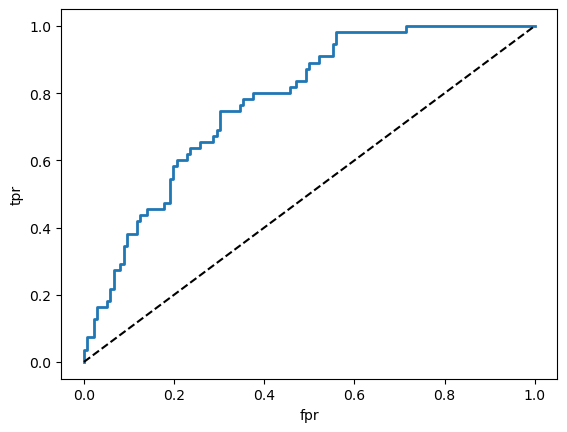

In [78]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

**최종적으로 파라미터도 함께 조정해보고 싶었으나 2시간 이상을 기다리고 조절을 해봐도 gs_rfc.fit(train_x, train_y) 결과가 나오지 않아    
기존의 파라미터를 사용하되 , 데이터 갯수와 K-fold를 5로 지정하여 데이터를 조절했습니다.**

**결론적으로 auc:0.7775401069518717 을 얻을 수 있었습니다.**